# Explore Icesat over channel

Wei ji has organised icesat data in the kamb channel study area. This notebook looks at it in more detail, looking at changes in height over time.

There isnt much data in the area, so in the end it just looks at a very specific icesat line near line 6

for an example of xarray in use https://github.com/weiji14/deepicedrain/blob/atl11_play/atl11_play.ipynb
to plot use https://hvplot.holoviz.org/

In [1]:


import rasterio as rio
import rasterio.mask
import fiona
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr
from shapely.geometry import Point
from shapely.geometry import LineString
import hvplot.xarray  # noqa
import cartopy.crs as crs
import hvplot.pandas


In [2]:
path = "/Volumes/arc_02/REMOTE_SENSING/ICESAT2/ds_subset_kamb_20200404.nc"


In [3]:
ds = xr.open_dataset(path, engine="h5netcdf")

In [4]:
# The data is in xarray format
ds

<xarray.Dataset>
Dimensions:                      (cycle_number: 7, poly_exponent_x: 8, poly_exponent_y: 8, ref_pt: 37945)
Coordinates:
  * cycle_number                 (cycle_number) int64 1 2 3 4 5 6 7
  * poly_exponent_x              (poly_exponent_x) int64 1 0 2 1 0 3 2 1
  * poly_exponent_y              (poly_exponent_y) int64 0 1 0 1 2 0 1 2
  * ref_pt                       (ref_pt) int64 1544442 1544445 ... 1464690
    x                            (ref_pt) float64 ...
    y                            (ref_pt) float64 ...
Data variables:
    at_slope                     (ref_pt) float64 ...
    complex_surface_flag         (ref_pt) float64 ...
    curvature                    (ref_pt) float64 ...
    deg_x                        (ref_pt) float64 ...
    deg_y                        (ref_pt) float64 ...
    delta_time                   (ref_pt, cycle_number) timedelta64[ns] ...
    dem_h                        (ref_pt) float64 ...
    e_slope                      (ref_pt) float64 ...
    h_corr                       (ref_pt, cycle_number) float64 ...
    h_corr_sigma                 (ref_pt, cycle_number) float64 ...
    h_corr_sigma_systematic      (ref_pt, cycle_number) float64 ...
    latitude                     (ref_pt) float64 ...
    longitude                    (ref_pt) float64 ...
    misfit_RMS                   (ref_pt) float64 ...
    misfit_chi2r                 (ref_pt) float64 ...
    n_slope                      (ref_pt) float64 ...
    poly_coeffs                  (ref_pt, poly_exponent_x) float64 ...
    poly_coeffs_sigma            (ref_pt, poly_exponent_x) float64 ...
    quality_summary_corrected_h  (ref_pt, cycle_number) float64 ...
    quality_summary_ref_surf     (ref_pt) float64 ...
    rgt_azimuth                  (ref_pt) float64 ...
    slope_change_rate_x          (ref_pt) float64 ...
    slope_change_rate_x_sigma    (ref_pt) float64 ...
    slope_change_rate_y          (ref_pt) float64 ...
    slope_change_rate_y_sigma    (ref_pt) float64 ...
    utc_time                     (ref_pt, cycle_number) datetime64[ns] ...
    x_atc                        (ref_pt) float64 ...
    xt_slope                     (ref_pt) float64 ...
    y_atc                        (ref_pt) float64 ...
Attributes:
    poly_exponent_x:  [1 0 2 1 0 3 2 1]
    poly_exponent_y:  [0 1 0 1 2 0 1 2]
    slope_change_t0:  29548800

In [5]:
# convert to pandas dataframe
dd = ds.drop_dims(['poly_exponent_x','poly_exponent_y'])
df = dd.to_dataframe()
df.reset_index(inplace=True)
df.keys()

Index(['cycle_number', 'ref_pt', 'at_slope', 'complex_surface_flag',
       'curvature', 'deg_x', 'deg_y', 'delta_time', 'dem_h', 'e_slope',
       'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude',
       'longitude', 'misfit_RMS', 'misfit_chi2r', 'n_slope',
       'quality_summary_corrected_h', 'quality_summary_ref_surf',
       'rgt_azimuth', 'slope_change_rate_x', 'slope_change_rate_x_sigma',
       'slope_change_rate_y', 'slope_change_rate_y_sigma', 'utc_time', 'x',
       'x_atc', 'xt_slope', 'y', 'y_atc'],
      dtype='object')

In [6]:
df = ds[["h_corr", "utc_time","h_corr_sigma"]].to_dataframe().reset_index()
df

cycle_number   ref_pt  h_corr utc_time  h_corr_sigma              x  \
0                  1  1544442     NaN      NaT           NaN -389988.100874   
1                  1  1544445     NaN      NaT           NaN -390001.349455   
2                  1  1544448     NaN      NaT           NaN -390014.605616   
3                  1  1544451     NaN      NaT           NaN -390027.889913   
4                  1  1544454     NaN      NaT           NaN -390041.659490   
...              ...      ...     ...      ...           ...            ...   
265610             7  1464678     NaN      NaT           NaN -388975.495203   
265611             7  1464681     NaN      NaT           NaN -388934.233161   
265612             7  1464684     NaN      NaT           NaN -388892.972333   
265613             7  1464687     NaN      NaT           NaN -388851.371993   
265614             7  1464690     NaN      NaT           NaN -388809.770835   

                    y  
0      -700200.620290  
1      -700257.397780  
2      -700314.173577  
3      -700370.942816  
4      -700427.598519  
...               ...  
265610 -699729.113947  
265611 -699687.906877  
265612 -699646.698328  
265613 -699605.835379  
265614 -699564.973641  

[265615 rows x 7 columns]

In [7]:
cycle_number = 4

df[df.cycle_number==cycle_number].hvplot.points(
    title=f"Elevation (metres) at Cycle {cycle_number}",
    x="x",
    y="y",
    c="h_corr",
    cmap="winter",
    rasterize=True,
    hover=True,
    clim=(-20, 200),
)


:DynamicMap   []
   :Image   [x,y]   (h_corr)

In [8]:
dh = (ds.sel(cycle_number=5).h_corr-ds.sel(cycle_number=3).h_corr).to_dataframe()


In [9]:
dh.hvplot.points(
    title=f"Elevation (metres) at Cycle {cycle_number}",
    x="x",
    y="y",
    c="h_corr",
    clim=(-1, 1),
    cmap="winter",
    rasterize=True,
    hover=True
)

:DynamicMap   []
   :Image   [x,y]   (h_corr)

In [10]:
line_name='line7'
gdf_line7 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
# study_area = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/PRE_FIELD/KISRoutes/study_area_buffer.shp')
line_name='line6'
gdf_line6 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
# study_area = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/PRE_FIELD/KISRoutes/study_area_buffer.shp')
line_name='line5'
gdf_line5 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
# study_area = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/PRE_FIELD/KISRoutes/study_area_buffer.shp')
line_name='line4'
gdf_line4 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")

line_name='line3'
gdf_line3 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
line_name='line2'
gdf_line2 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
line_name='line1'
gdf_line1 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")

line_name='line0'
gdf_line0 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")

### Plot the data in the area to see which cycles have more relevant data

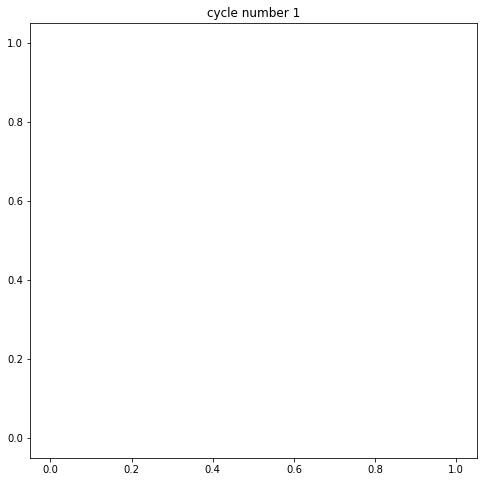

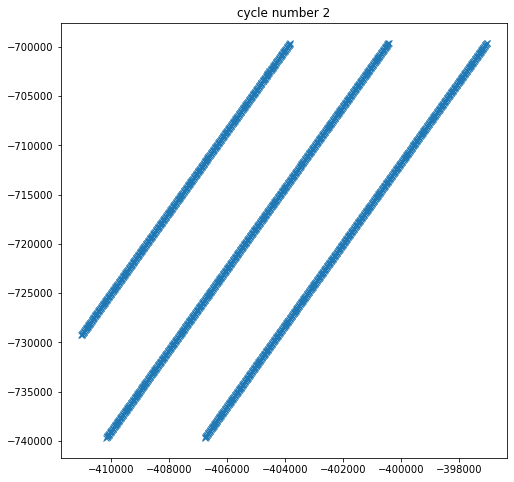

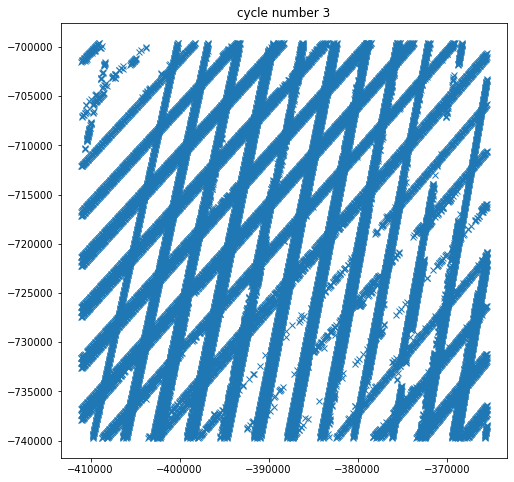

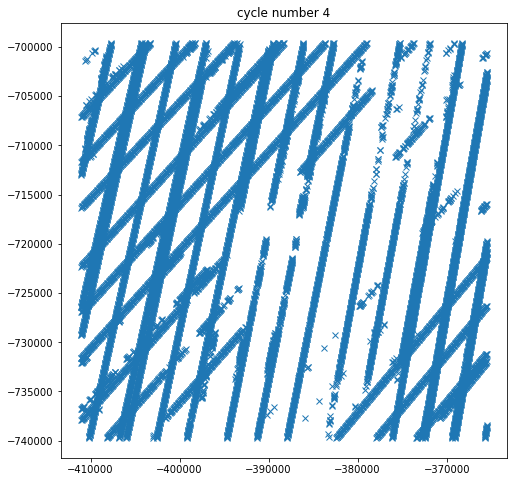

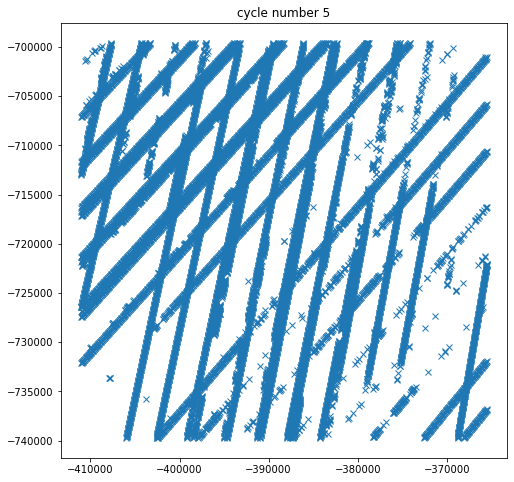

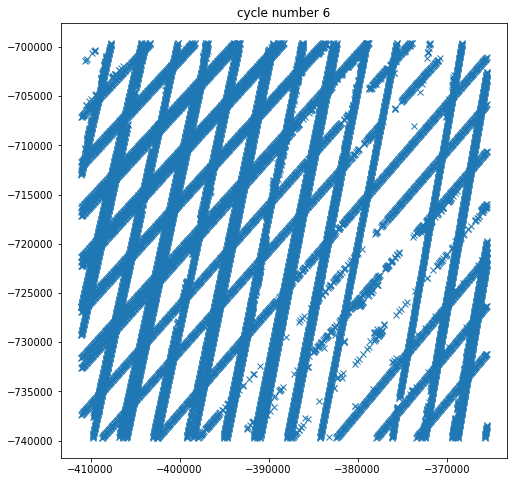

In [11]:
for cycle_number in range(1,7):

    plt.figure(figsize=(8,8))
    plt.plot(df[df.cycle_number==cycle_number].dropna().x,df[df.cycle_number==cycle_number].dropna().y,'x')
    plt.title(f"cycle number {cycle_number}")

### As above but with radar lines 5-7 for reference

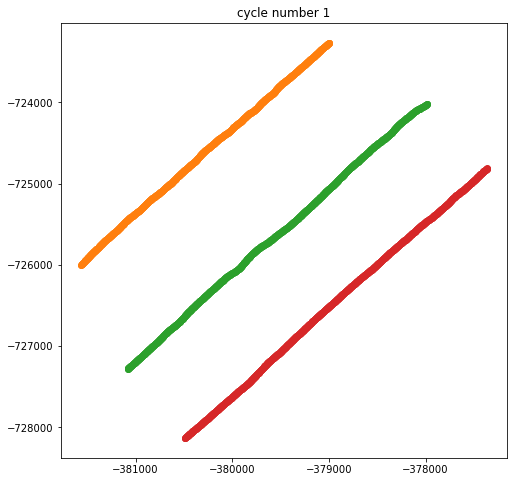

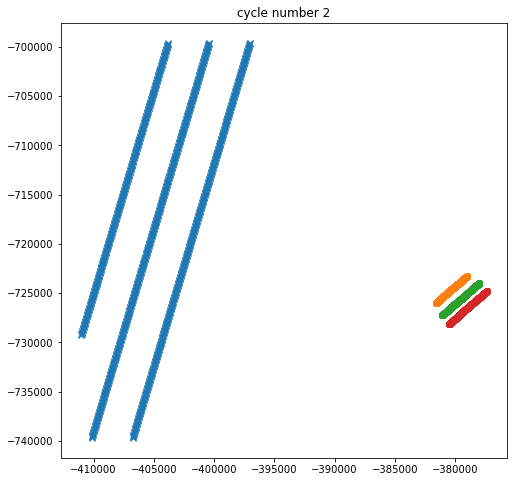

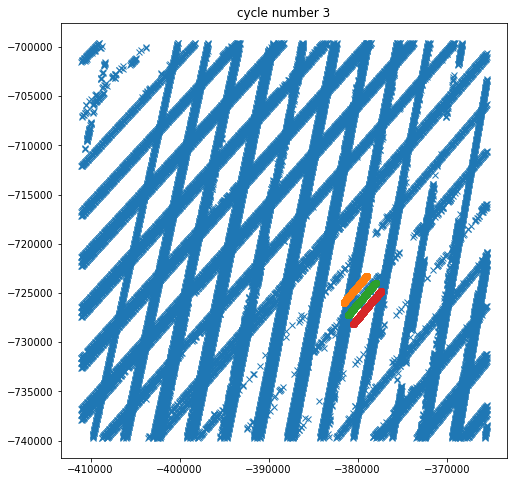

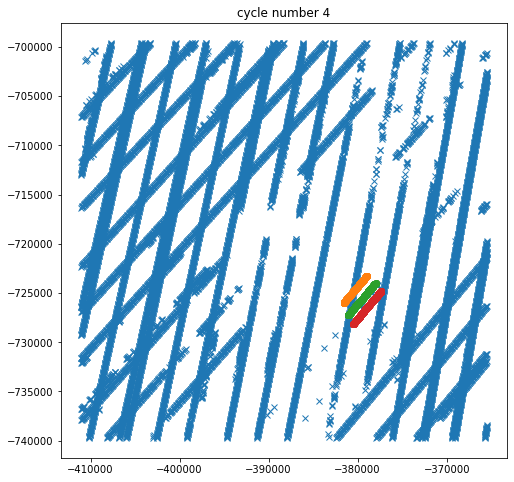

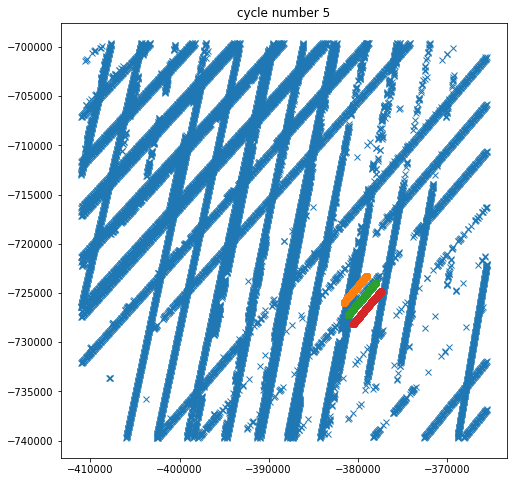

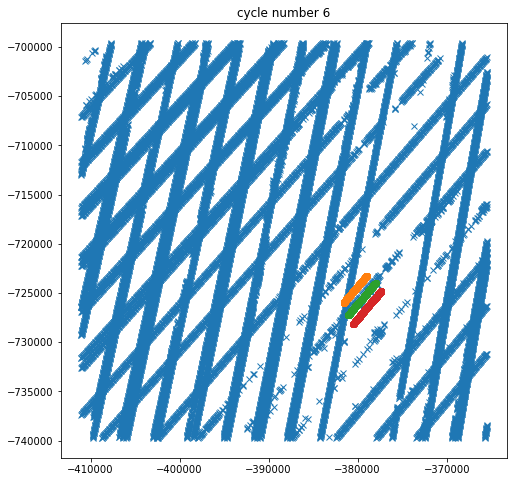

In [12]:
for cycle_number in range(1,7):

    plt.figure(figsize=(8,8))
    plt.plot(df[df.cycle_number==cycle_number].dropna().x,df[df.cycle_number==cycle_number].dropna().y,'x')
    plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,'o')
    plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,'o')
    plt.plot(gdf_line5.geometry.x,gdf_line5.geometry.y,'o')
    
    plt.title(f"cycle number {cycle_number}")

In [13]:
for cycle_number in range(1,7):
    print(f"cycle number {cycle_number} has {df[df.cycle_number==cycle_number].dropna().shape[0]} points")
    print(f"cycle number {cycle_number} is at {df[df.cycle_number==cycle_number].utc_time.mean().date()}")

cycle number 1 has 0 points
cycle number 1 is at NaT
cycle number 2 has 1943 points
cycle number 2 is at 2019-03-28
cycle number 3 has 32886 points
cycle number 3 is at 2019-05-13
cycle number 4 has 16728 points
cycle number 4 is at 2019-08-29
cycle number 5 has 18511 points
cycle number 5 is at 2019-11-07
cycle number 6 has 26075 points
cycle number 6 is at 2020-02-12


## Looking at this:

Cycle 3 has the most points, and most cycles leave out our important points. However line 6 has some icesat2 points close by

In [14]:
cycle_number= 3
plt.figure(figsize=(8,8))
plt.plot(df[df.cycle_number==cycle_number].dropna().x,df[df.cycle_number==cycle_number].dropna().y,'x')
plt.xlim(gdf_line6.geometry.x.min(),gdf_line6.geometry.x.max())
plt.ylim(gdf_line6.geometry.y.min(),gdf_line6.geometry.y.max()+400)
plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,'-')
plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,':')
plt.legend([f'icesat2—cycle {cycle_number}','line 6','line 7'])
plt.title(f"cycle number {cycle_number}")

Text(0.5, 1.0, 'cycle number 3')

Text(0.5, 1.0, 'cycle number 4')

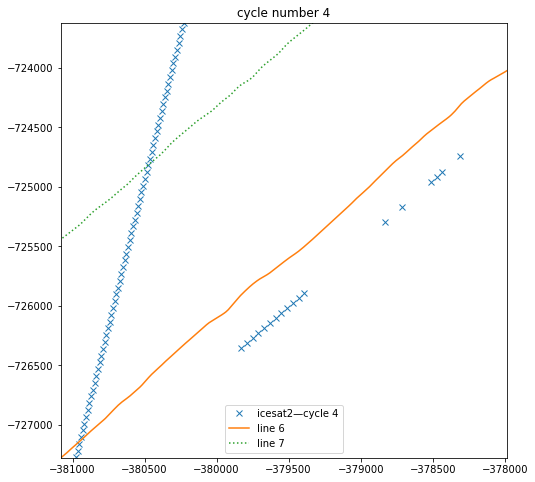

In [15]:
cycle_number= 4
plt.figure(figsize=(8,8))
plt.plot(df[df.cycle_number==cycle_number].dropna().x,df[df.cycle_number==cycle_number].dropna().y,'x')
plt.xlim(gdf_line6.geometry.x.min(),gdf_line6.geometry.x.max())
plt.ylim(gdf_line6.geometry.y.min(),gdf_line6.geometry.y.max()+400)
plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,'-')
plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,':')
plt.legend([f'icesat2—cycle {cycle_number}','line 6','line 7'])
plt.title(f"cycle number {cycle_number}")

Text(0.5, 1.0, 'cycle number 5')

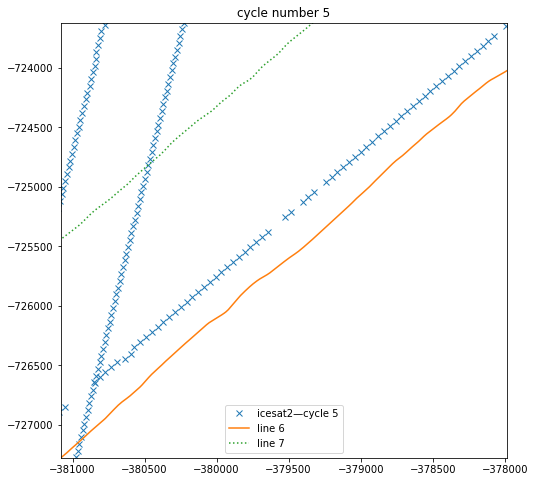

In [16]:
cycle_number= 5
plt.figure(figsize=(8,8))
plt.plot(df[df.cycle_number==cycle_number].dropna().x,df[df.cycle_number==cycle_number].dropna().y,'x')
plt.xlim(gdf_line6.geometry.x.min(),gdf_line6.geometry.x.max())
plt.ylim(gdf_line6.geometry.y.min(),gdf_line6.geometry.y.max()+400)
plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,'-')
plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,':')
plt.legend([f'icesat2—cycle {cycle_number}','line 6','line 7'])
plt.title(f"cycle number {cycle_number}")

In [99]:
#do a difference of icesat near line 6, between cycle 5 and 3
dh_cycle53 = (ds.sel(cycle_number=5).h_corr-ds.sel(cycle_number=3).h_corr).to_dataframe()
dh_corr_sigma = (ds.sel(cycle_number=5).h_corr_sigma+ds.sel(cycle_number=3).h_corr_sigma).to_dataframe()
dh_cycle53['h_corr_sigma']= dh_corr_sigma.h_corr_sigma
dh_cycle53 = dh_cycle53.dropna()

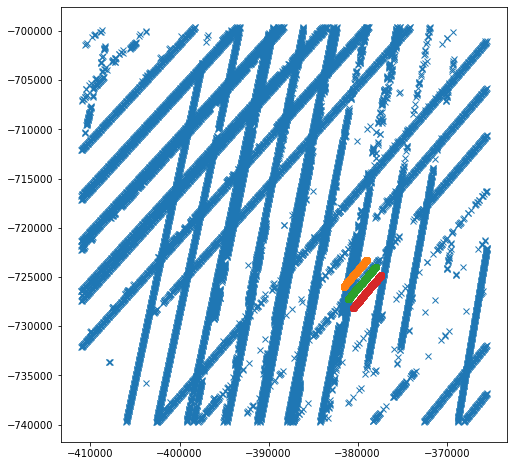

In [18]:
plt.figure(figsize=(8,8))
plt.plot(dh_cycle53.x,dh_cycle53.y,'x')
plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,'o')
plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,'o')
plt.plot(gdf_line5.geometry.x,gdf_line5.geometry.y,'o')

So we have about one line of coverage. Lets isolate this to a buffer around line 6

In [19]:
line6 = LineString(gdf_line6.geometry.tolist())

In [115]:
cycle_number=3
df_cycle3 = df[df.cycle_number==cycle_number]
points = [Point(xy) for xy in zip(df_cycle3.x,df_cycle3.y)]
gdf_cycle3 = gpd.GeoDataFrame(df_cycle3,geometry=points)
gdf_cycle3['intersects_line6'] = gdf_cycle3.geometry.intersects(line6.buffer(300))
near_3 = gdf_cycle3[df_cycle3.intersects_line6==True].dropna()

In [116]:
cycle_number=5
df_cycle5 = df[df.cycle_number==cycle_number]
points = [Point(xy) for xy in zip(df_cycle5.x,df_cycle5.y)]
gdf_cycle5 = gpd.GeoDataFrame(df_cycle5,geometry=points)
gdf_cycle5['intersects_line6'] = gdf_cycle5.geometry.intersects(line6.buffer(300))
near_5 = gdf_cycle5[gdf_cycle5.intersects_line6==True].dropna()

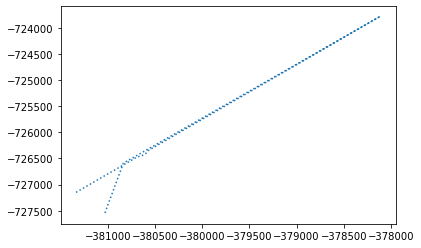

In [138]:
# plt.plot(near_3.x,near_3.y,'x')
plt.plot(near_5.x,near_5.y,':')

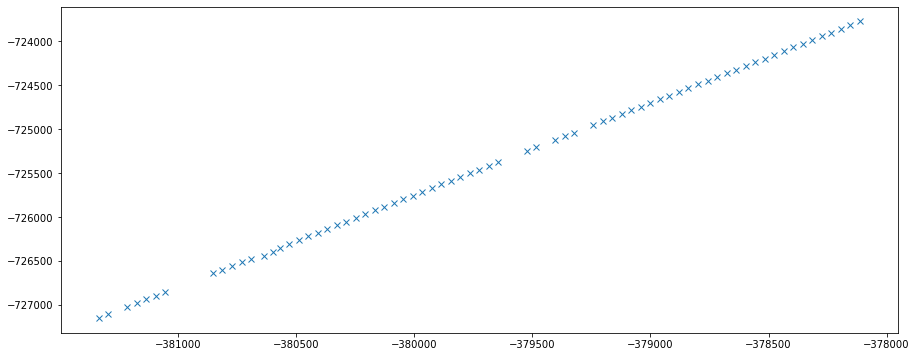

In [153]:
plt.figure(figsize=(15,6))
ff5=0
tt5=-18
# plt.plot(near_3.x.iloc[ff5:tt5],near_3.h_corr.iloc[ff5:tt5],'x')
plt.plot(near_5.x.iloc[ff5:tt5],near_5.y.iloc[ff5:tt5],'x')

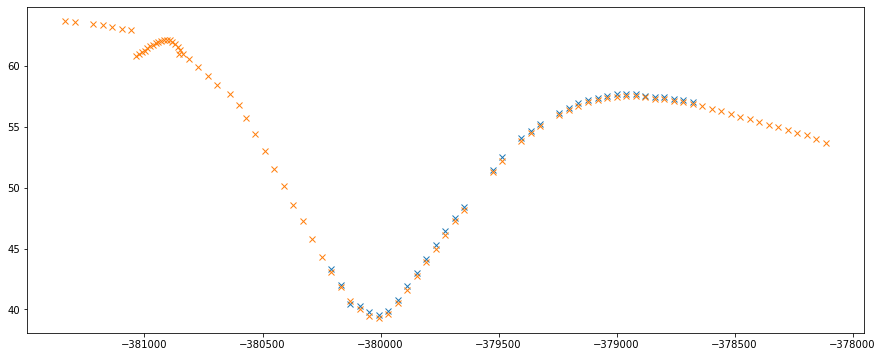

In [137]:
plt.figure(figsize=(15,6))
ff3=40
tt3=-40
plt.plot(near_3.x.iloc[ff5:tt5],near_3.h_corr.iloc[ff5:tt5],'x')
plt.plot(near_5.x.iloc[ff5:tt5],near_5.h_corr.iloc[ff5:tt5],':')

In [109]:
near6_3=near_3.iloc[ff5:tt5]
near6_5=near_5.iloc[ff5:tt5]
near6_5.shape

(71, 9)

In [110]:
plt.plot(near6_3.x,near6_3.y,'x')
plt.plot(near6_5.x,near6_5.y,'x')

In [111]:
points = [Point(xy) for xy in zip(dh_cycle53.x,dh_cycle53.y)]
gdh_cycle53 = gpd.GeoDataFrame(dh_cycle53,geometry=points)

88898    NaN
88899    NaN
88900    NaN
88901    NaN
88902    NaN
          ..
164854   NaN
164855   NaN
164856   NaN
164857   NaN
170877   NaN
Name: h_corr, Length: 142, dtype: float64

In [112]:
gdh_cycle53['intersects_line6'] = gdh_cycle53.geometry.intersects(line6.buffer(300))
dh_near_line6 = gdh_cycle53[gdh_cycle53.intersects_line6==True].iloc[ff5:tt5]
dh_near_line6.shape

(46, 6)

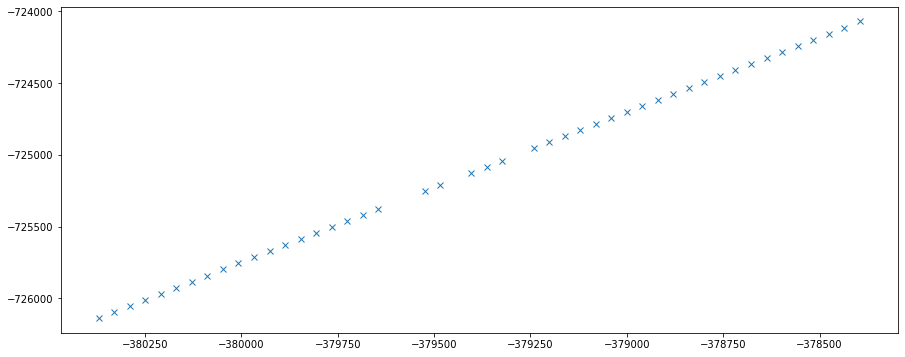

In [105]:
plt.figure(figsize=(15,6))
plt.plot(dh_near_line6.x,dh_near_line6.y,'x')

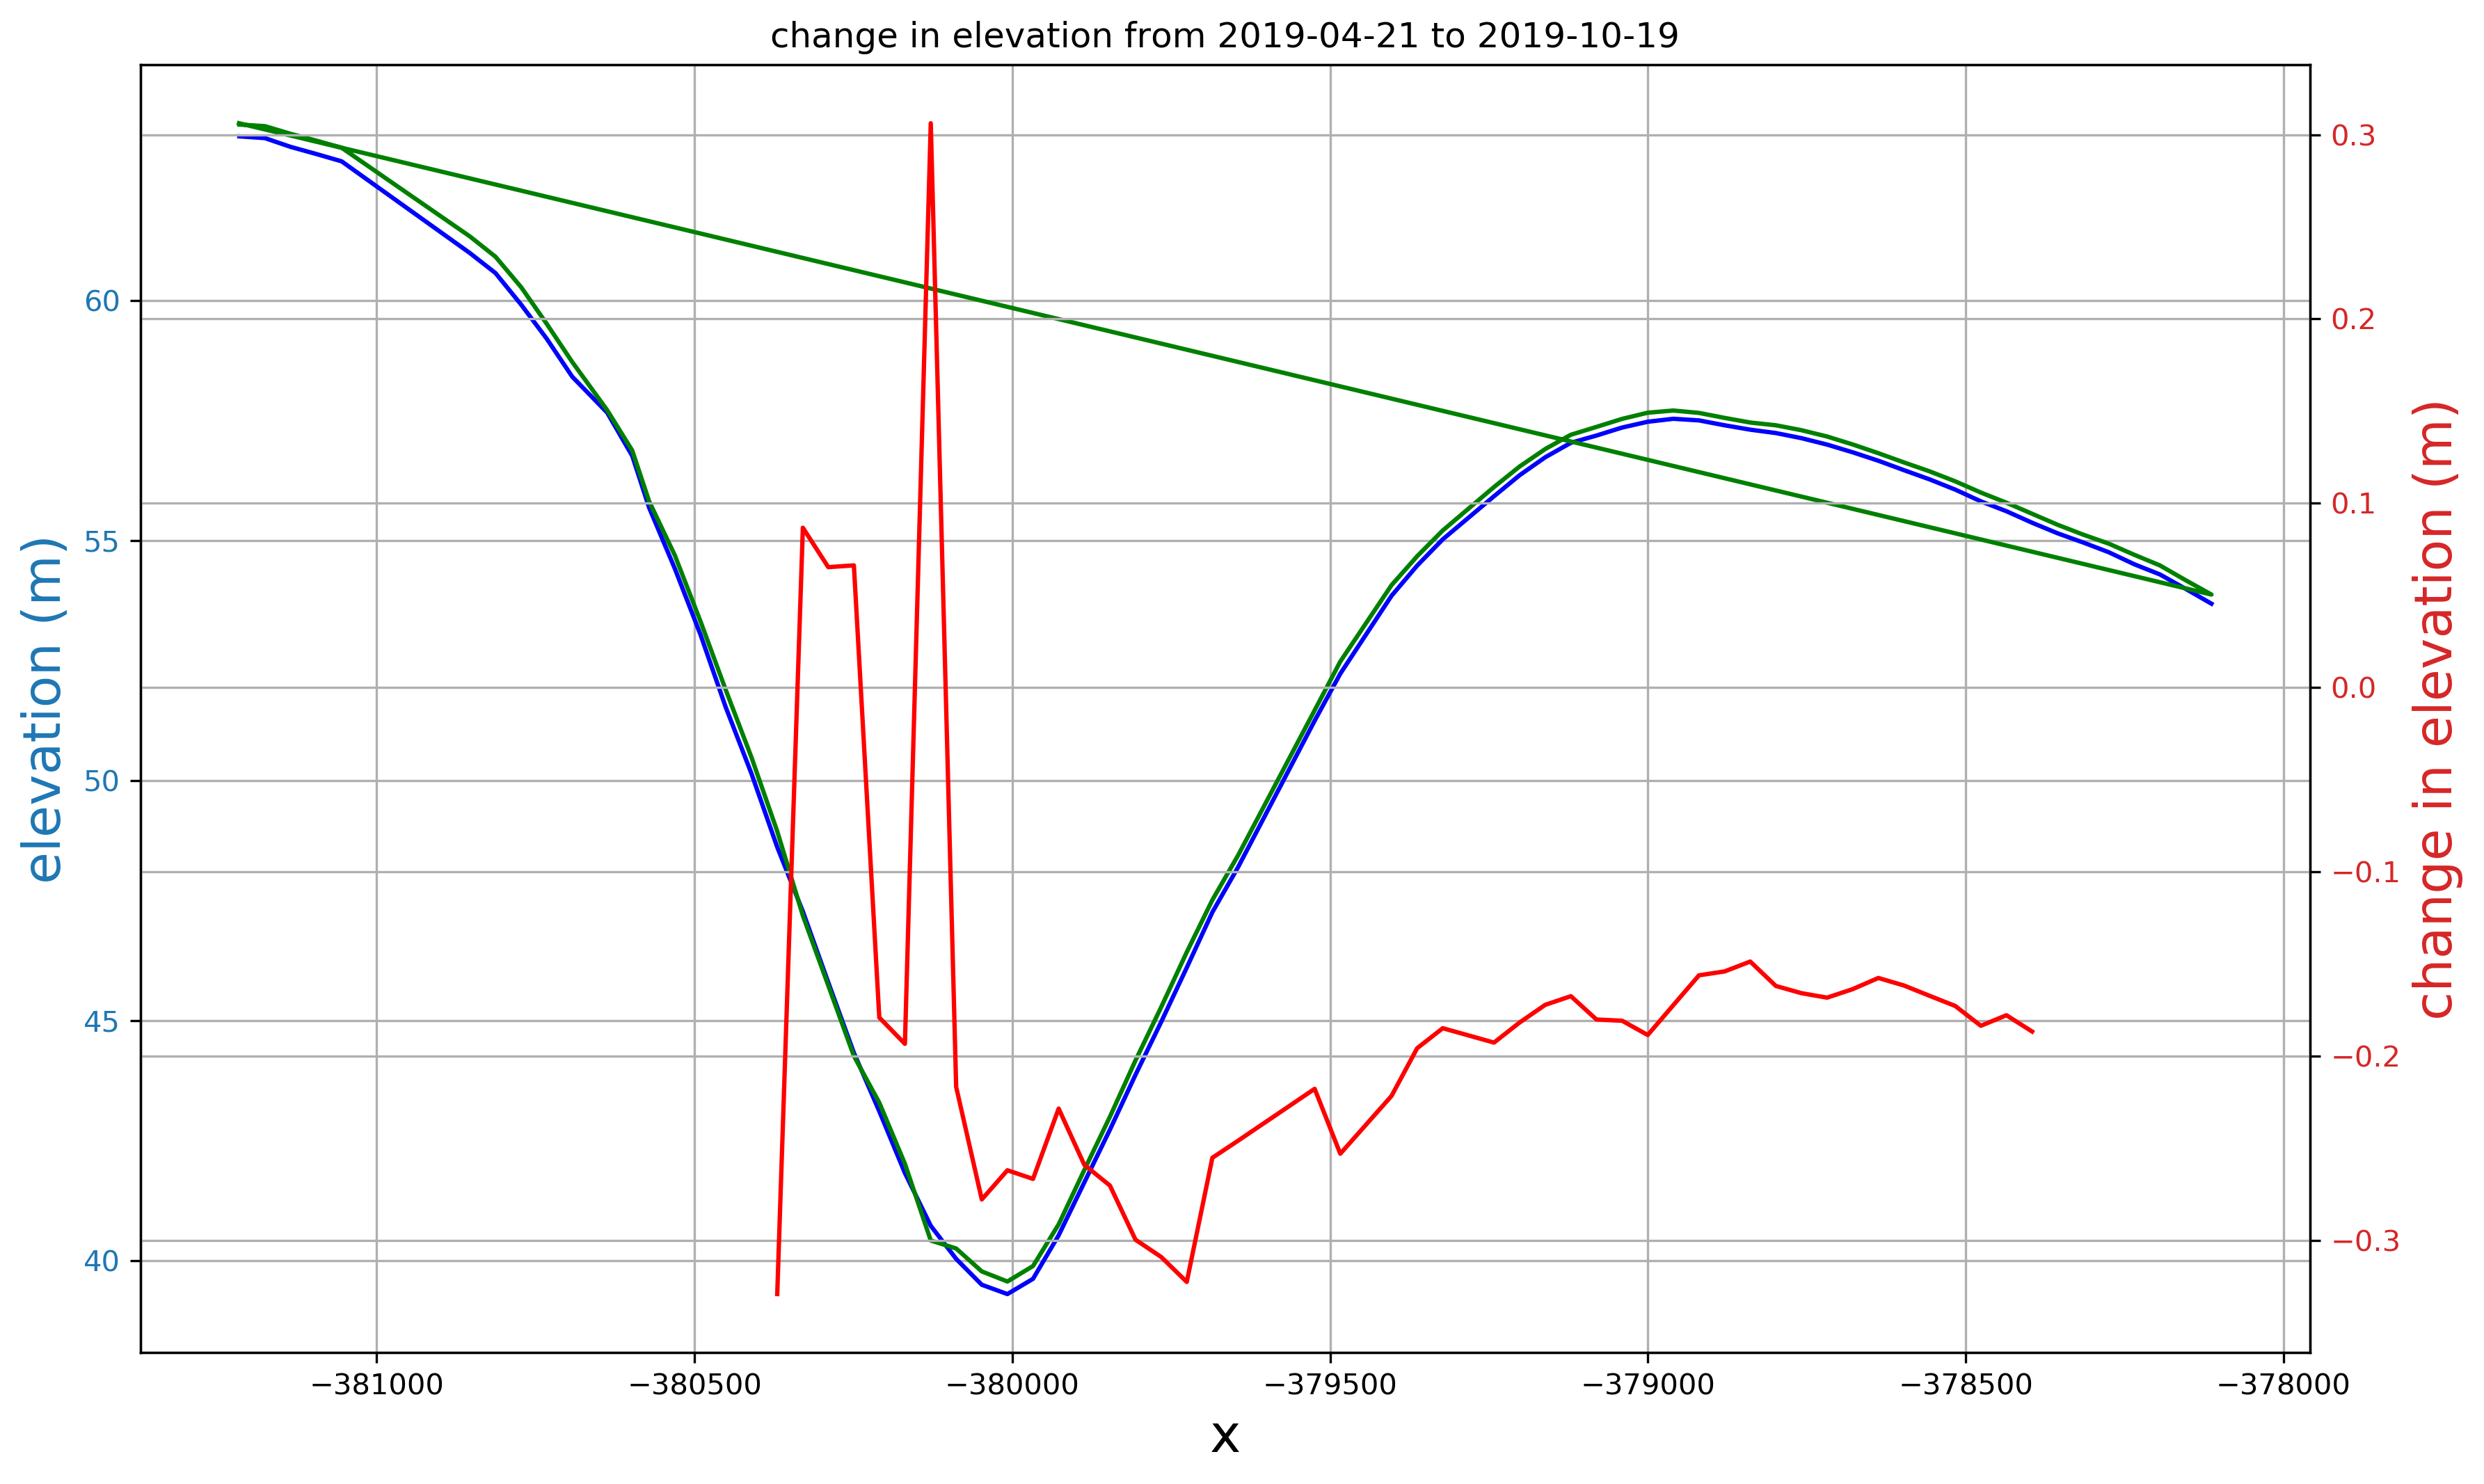

In [97]:
fig, ax1 = plt.subplots(figsize=(12,7),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('x',fontsize=18)
ax1.set_ylabel('elevation (m)', color=color,fontsize=18)
ax1.plot(near6_5.x,near6_5.h_corr,'b-')
ax1.plot(near6_3.x,near6_3.h_corr,'g-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('change in elevation (m)', color=color,fontsize=18)  # we already handled the x-label with ax1
ax2.plot(dh_near_line6.x,dh_near_line6.h_corr,'r-')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f"change in elevation from {near6_3.utc_time.mean().date()} to {near6_5.utc_time.mean().date()}")
plt.show()

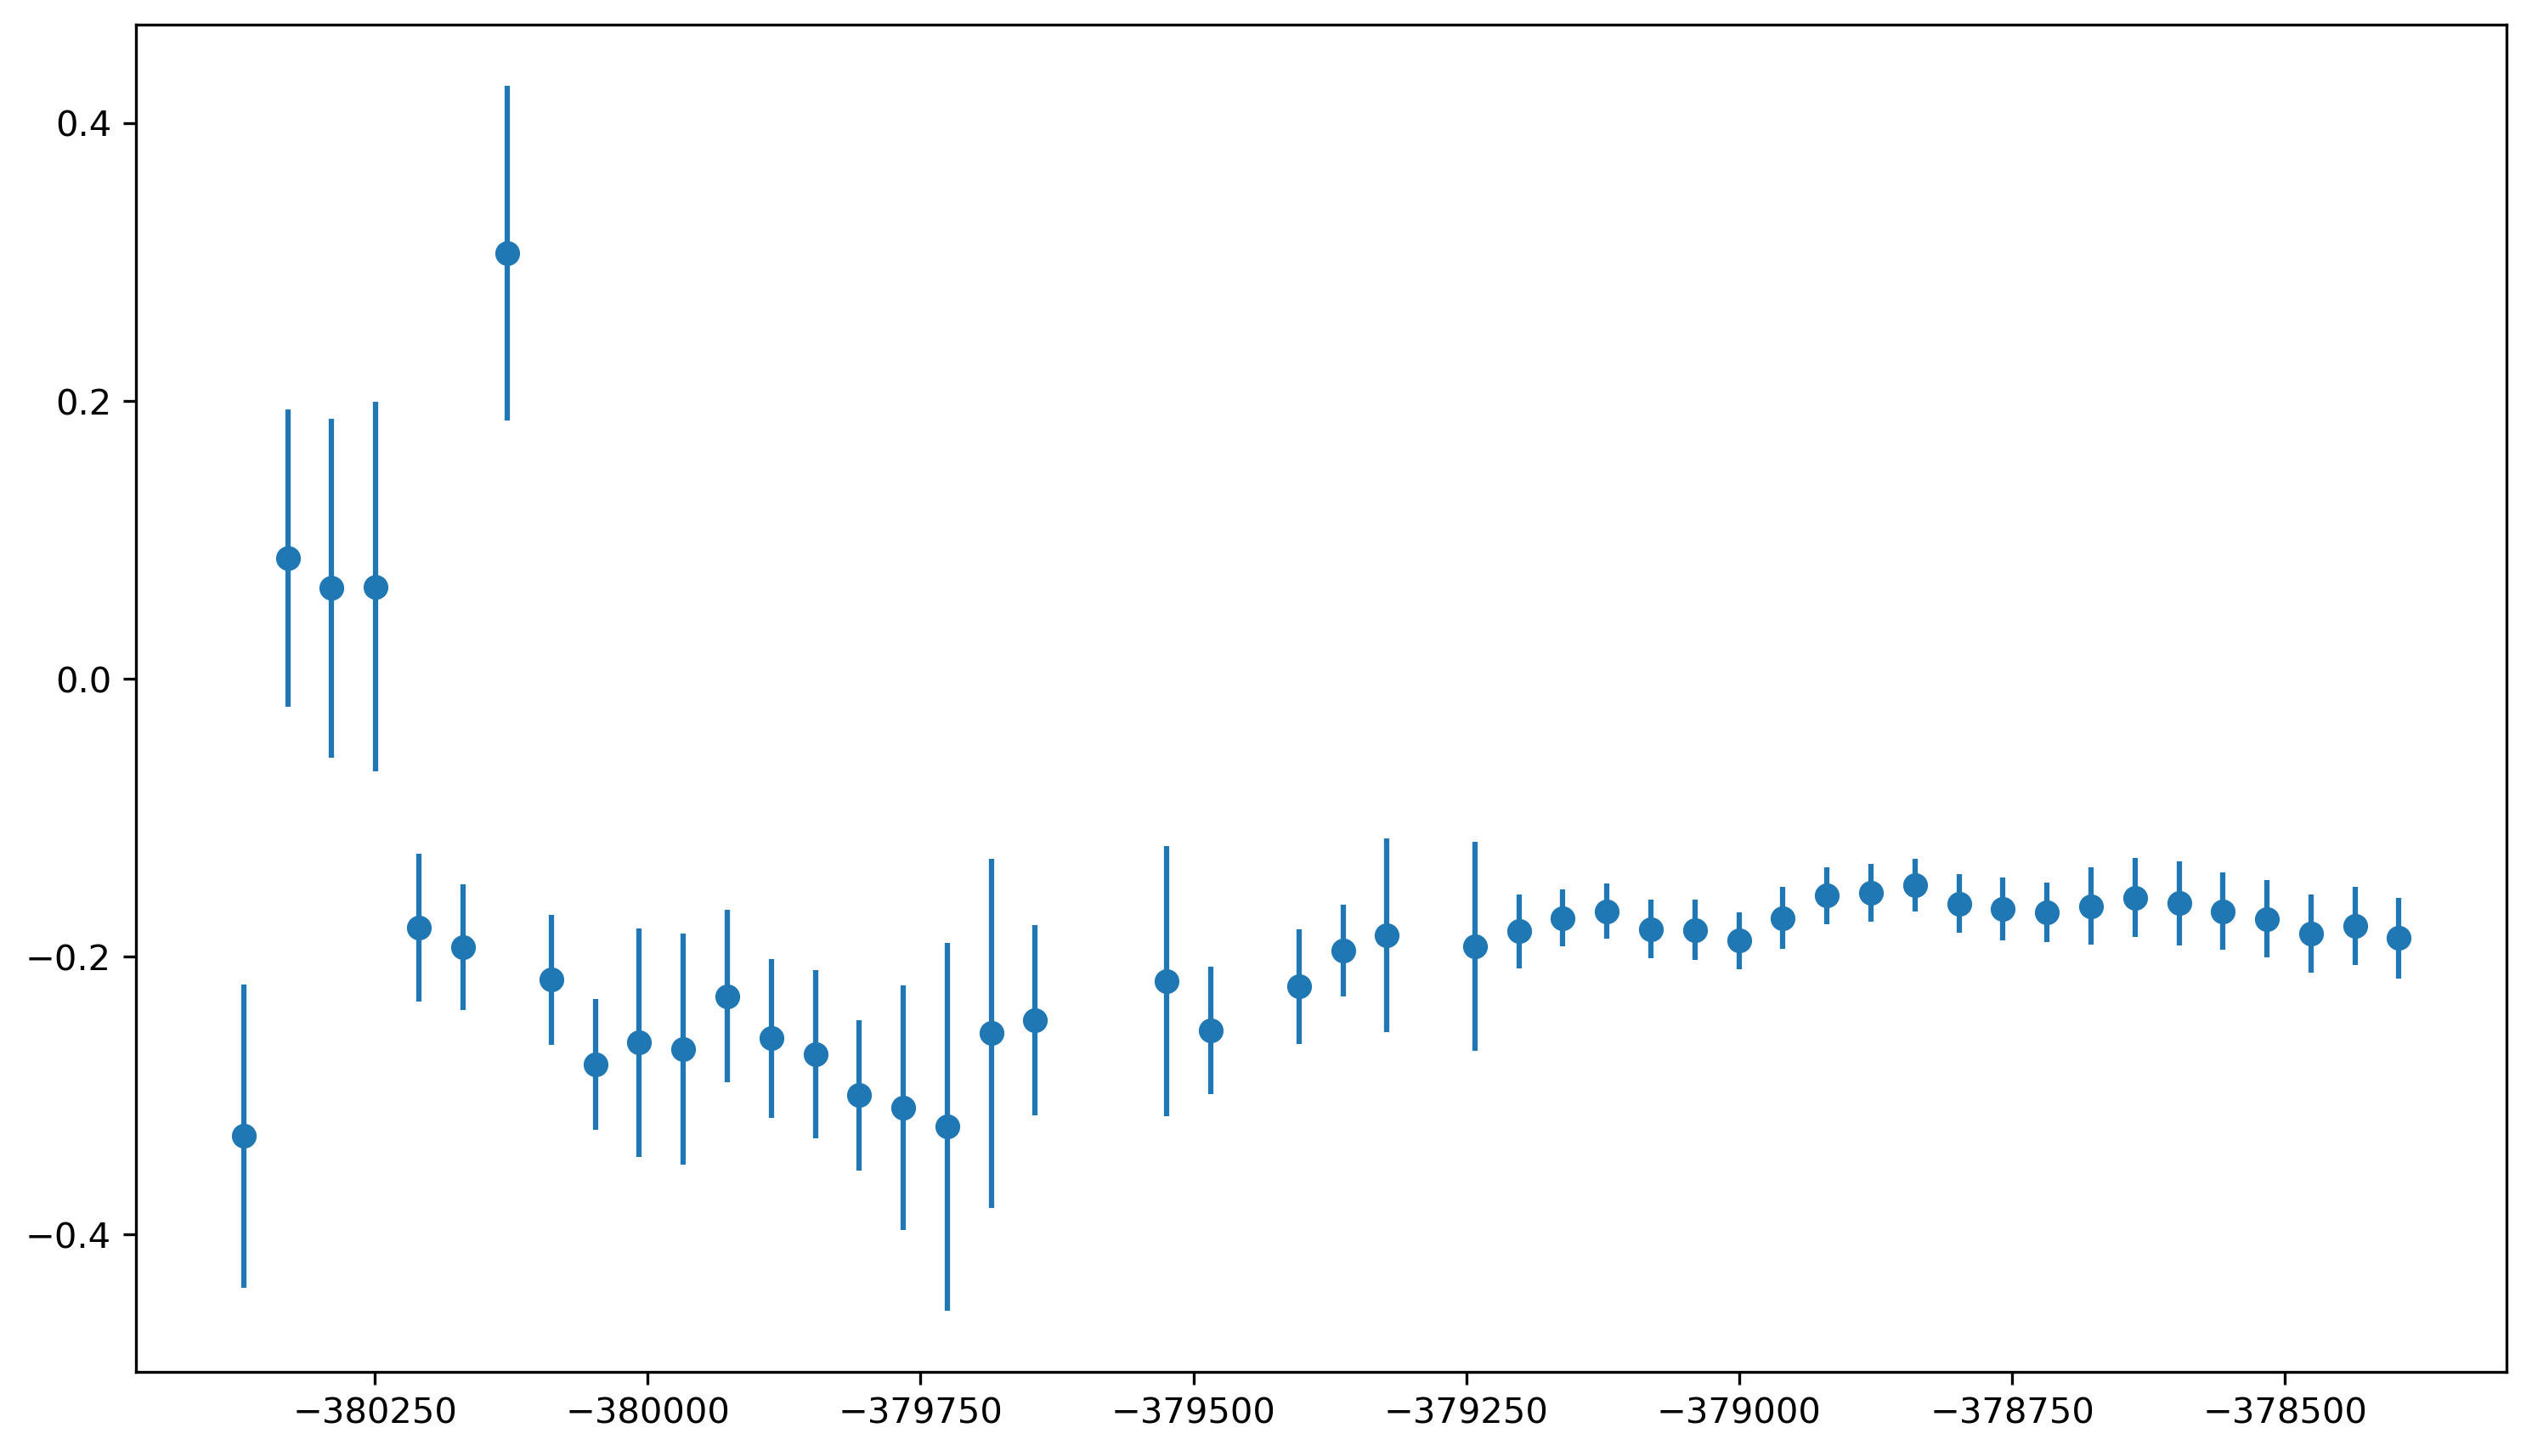

In [98]:
#plot with error bars
plt.figure(figsize=(12,7),dpi=300)
plt.errorbar(dh_near_line6.x,dh_near_line6.h_corr,yerr=dh_near_line6.h_corr_sigma,xerr=0,marker='o',linestyle="None")
plt.show()

In [31]:
f = interpolate.interp1d( [dh_near_line6.x.iloc[0],dh_near_line6.x.iloc[-1]], [dh_near_line6.h_corr.iloc[0],dh_near_line6.h_corr.iloc[-1]])
trendline = f(dh_near_line6.x)
adjusted =dh_near_line6.h_corr-trendline

ValueError: A value in x_new is above the interpolation range.

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,7),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('x',fontsize=18)
ax1.set_ylabel('elevation (m)', color=color,fontsize=18)
ax1.plot(near6_5.x,near6_5.h_corr,'b-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('change in elevation (m)', color=color,fontsize=18)  # we already handled the x-label with ax1
ax2.plot(dh_near_line6.x,adjusted,'ro')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f"change in elevation from {near6_3.utc_time.mean().date()} to {near6_5.utc_time.mean().date()}")
plt.show()

The above plot shows accretion near line 6

## IE we may have an accretion signal in icesat2

next I want to look for a melt signal, if there are any points around the melt area
# Do the same but near line 7

So we have about one line of coverage. Lets isolate this to a buffer around line 7

In [ ]:
line7 = LineString(gdf_line7.geometry.tolist())

In [ ]:
gdf_cycle3['intersects_line7'] = gdf_cycle3.geometry.intersects(line7.buffer(300))
near7_3 = gdf_cycle3[df_cycle3.intersects_line7==True]

In [ ]:
gdf_cycle5['intersects_line7'] = gdf_cycle5.geometry.intersects(line7.buffer(300))
near7_5 = gdf_cycle5[gdf_cycle5.intersects_line7==True]

In [ ]:
plt.plot(near7_3.x,near7_3.h_corr,'x')
plt.plot(near7_5.x,near7_5.h_corr)

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(near7_3.x.iloc[1:11],near7_3.h_corr.iloc[1:11],'x')
plt.plot(near7_5.x,near7_5.h_corr)

In [ ]:
near7_3=near7_3.iloc[1:11]

In [ ]:
gdh_cycle53['intersects_line7'] = gdh_cycle53.geometry.intersects(line7.buffer(300))
dh_near_line7 = gdh_cycle53[gdh_cycle53.intersects_line7==True]
# dh_near_line6

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(dh_near_line7.x,dh_near_line7.h_corr,'x')

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,7),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('x',fontsize=18)
ax1.set_ylabel('elevation (m)', color=color,fontsize=18)
ax1.plot(near7_5.x,near7_5.h_corr,'b-')
ax1.plot(near7_3.x.iloc[1:11],near7_3.h_corr.iloc[1:11],'g-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('change in elevation (m)', color=color,fontsize=18)  # we already handled the x-label with ax1
ax2.plot(dh_near_line7.x,dh_near_line7.h_corr,'r-')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f"change in elevation from {near7_3.utc_time.mean().date()} to {near7_5.utc_time.mean().date()}")
plt.show()

In [ ]:
#plot with error bars
plt.figure(figsize=(12,7),dpi=300)
plt.errorbar(dh_near_line7.x,dh_near_line7.h_corr,yerr=dh_near_line7.h_corr_sigma,xerr=0,marker='o',linestyle="None")

In [ ]:
f = interpolate.interp1d( [dh_near_line7.x.iloc[0],dh_near_line7.x.iloc[-1]], [dh_near_line7.h_corr.iloc[0],dh_near_line7.h_corr.iloc[-1]])
trendline = f(dh_near_line7.x)
adjusted7 =dh_near_line7.h_corr-trendline

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,7),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('x',fontsize=18)
ax1.set_ylabel('elevation (m)', color=color,fontsize=18)
ax1.plot(near7_5.x,near7_5.h_corr,'b-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('change in elevation (m)', color=color,fontsize=18)  # we already handled the x-label with ax1
ax2.plot(dh_near_line7.x,adjusted7,'ro')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f"change in elevation from {near7_3.utc_time.mean().date()} to {near7_5.utc_time.mean().date()}")
plt.show()

# Conclusion

I could dig further into the few points in the melt area, but its not very interesting, REMA has much much better coverage for looking at the melt signal. However it is interesting that we can see accretion near line 6

# Contuinue digging

In [ ]:
melt_area = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/melt_area_REMA.shp')

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(dh_cycle53.x,dh_cycle53.y,'x')
plt.plot(melt_area.iloc[0].geometry.exterior.xy[0],melt_area.iloc[0].geometry.exterior.xy[1],'x')
plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,':')
plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,':')

fig above shows melt area relative to icesat2 lines

In [ ]:
gdh_cycle53['intersects_melt_area'] = gdh_cycle53.geometry.intersects(melt_area.iloc[0].geometry.buffer(300))
dh_near_melt_area = gdh_cycle53[gdh_cycle53.intersects_melt_area==True]

In [ ]:
melt = Point(-380650, -725450)
accr = Point(-377950,-729050)

In [ ]:
plt.figure(figsize=(12,12))
plt.scatter(dh_near_melt_area.x,dh_near_melt_area.y,c=dh_near_melt_area.h_corr,cmap='winter')
plt.plot(melt_area.iloc[0].geometry.exterior.xy[0],melt_area.iloc[0].geometry.exterior.xy[1],'-')
plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,':')
plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,':')
plt.xlim(dh_near_melt_area.x.min()-1000,dh_near_melt_area.x.max())
plt.ylim(dh_near_melt_area.y.min(),dh_near_melt_area.y.max())
plt.plot(melt.x,melt.y,'y^')
plt.plot(accr.x,accr.y,'rs')
plt.legend(['melt_area','line 7', 'line 6','melt_rate','melt centre','accretion'])
plt.colorbar()
plt.grid()

In [ ]:
gdh_cycle53['intersects_melt_area'] = gdh_cycle53.geometry.intersects(melt_area.iloc[0].geometry.buffer(2000))
dh_near_melt_area = gdh_cycle53[gdh_cycle53.intersects_melt_area==True]
plt.figure(figsize=(12,12))
plt.scatter(dh_near_melt_area.x,dh_near_melt_area.y,c=dh_near_melt_area.h_corr,cmap='winter')
plt.plot(melt_area.iloc[0].geometry.exterior.xy[0],melt_area.iloc[0].geometry.exterior.xy[1],'-')
plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,':')
plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,':')
plt.plot(melt.x,melt.y,'y^')
plt.plot(accr.x,accr.y,'rs')
plt.legend(['melt_area','line 7', 'line 6','melt_rate','melt centre'])
plt.colorbar()
plt.grid()

In [ ]:
gdh_cycle53['intersects_melt_area'] = gdh_cycle53.geometry.intersects(melt_area.iloc[0].geometry.buffer(8000))
dh_near_melt_area = gdh_cycle53[gdh_cycle53.intersects_melt_area==True]
plt.figure(figsize=(12,12))
plt.scatter(dh_near_melt_area.x,dh_near_melt_area.y,c=dh_near_melt_area.h_corr,cmap='winter')
plt.plot(melt_area.iloc[0].geometry.exterior.xy[0],melt_area.iloc[0].geometry.exterior.xy[1],'-')
plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,':')
plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,':')
plt.plot(gdf_line5.geometry.x,gdf_line5.geometry.y,':')
plt.plot(gdf_line4.geometry.x,gdf_line4.geometry.y,':')
plt.plot(gdf_line3.geometry.x,gdf_line3.geometry.y,':')
plt.plot(gdf_line2.geometry.x,gdf_line2.geometry.y,':')
plt.plot(gdf_line1.geometry.x,gdf_line1.geometry.y,':')
plt.plot(gdf_line0.geometry.x,gdf_line0.geometry.y,':')
plt.plot(melt.x,melt.y,'y^')
plt.plot(accr.x,accr.y,'rs')
plt.legend(['melt_area','line 7', 'line 6','line 5','line 4','line 3','line 2','line 1','line 0','melt_rate','melt centre','accretion'])
plt.colorbar()
plt.grid()

# So using icesat2 we have identified areas of accretion and melt

### 1. Melt next to KIS2

also note that just downstream is accretion

In [ ]:
gdh_cycle53['intersects_melt_area'] = gdh_cycle53.geometry.intersects(melt_area.iloc[0].geometry)
dh_near_melt_area = gdh_cycle53[gdh_cycle53.intersects_melt_area==True]
plt.figure(figsize=(12,12))
plt.scatter(dh_near_melt_area.x,dh_near_melt_area.y,c=dh_near_melt_area.h_corr,cmap='winter')
plt.plot(melt_area.iloc[0].geometry.exterior.xy[0],melt_area.iloc[0].geometry.exterior.xy[1],'-')
plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,':')
plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,':')
plt.xlim(dh_near_melt_area.x.min(),dh_near_melt_area.x.max())
plt.ylim(dh_near_melt_area.y.min(),dh_near_melt_area.y.max())
plt.plot(melt.x,melt.y,'y^')
plt.plot(accr.x,accr.y,'rs')
plt.legend(['melt_area','line 7', 'line 6','melt_rate','melt centre'])
plt.colorbar()
plt.grid()

### 2. Accretion at line 3

In [ ]:
gdh_cycle53['intersects_melt_area'] = gdh_cycle53.geometry.intersects(melt_area.iloc[0].geometry.buffer(6000))
dh_near_melt_area = gdh_cycle53[gdh_cycle53.intersects_melt_area==True]
plt.figure(figsize=(12,12))
plt.scatter(dh_near_melt_area.x,dh_near_melt_area.y,c=dh_near_melt_area.h_corr,cmap='winter')
plt.plot(gdf_line4.geometry.x,gdf_line4.geometry.y,':')
plt.plot(gdf_line3.geometry.x,gdf_line3.geometry.y,':')
plt.plot(gdf_line2.geometry.x,gdf_line2.geometry.y,':')
plt.xlim(gdf_line3.geometry.x.min()+200,gdf_line3.geometry.x.max()-200)
plt.ylim(gdf_line3.geometry.y.min()+200,gdf_line3.geometry.y.max()-200)
plt.plot(accr.x,accr.y,'rs')
plt.legend(['melt_rate','line 4','line 3','line 2','accretion centre'])
plt.colorbar()
plt.grid()

In [ ]:
accretion_centre = Point(-377950,-729050)
gdh_cycle53['intersects_acc'] = gdh_cycle53.geometry.intersects(accretion_centre.buffer(800))
dh_near_acc = gdh_cycle53[gdh_cycle53.intersects_acc==True]

In [ ]:
plt.scatter(dh_near_acc.x,dh_near_acc.y,c=dh_near_acc.h_corr,cmap='winter')
plt.plot(-377950,-729050,'s')

In [ ]:
f = 19
t =-1
plt.scatter(dh_near_acc.x.iloc[f:t],dh_near_acc.y.iloc[f:t],c=dh_near_acc.h_corr.iloc[f:t],cmap='winter')
plt.plot(-377950,-729050,'s')
plt.colorbar()

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(dh_near_acc.x.iloc[f:t],dh_near_acc.h_corr.iloc[f:t],'o')
plt.grid()
plt.ylabel('change in elevation (m)')

In [ ]:
gdf_cycle3['near_acc'] = gdf_cycle3.geometry.intersects(accretion_centre.buffer(800))
nearacc_3 = gdf_cycle3[gdf_cycle3.near_acc==True]

In [ ]:
gdf_cycle5['near_acc'] = gdf_cycle5.geometry.intersects(accretion_centre.buffer(800))
nearacc7_5 = gdf_cycle5[gdf_cycle5.near_acc==True]

In [ ]:
ff=22
tt=-1
plt.plot(nearacc7_5.x[ff:tt],nearacc7_5.y[ff:tt],'x')

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,7),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('x',fontsize=18)
ax1.set_ylabel('elevation (m)', color=color,fontsize=18)
ax1.plot(nearacc7_5.x[ff:tt],nearacc7_5.h_corr[ff:tt],'b-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('change in elevation (m)', color=color,fontsize=18)  # we already handled the x-label with ax1
ax2.plot(dh_near_acc.x.iloc[f:t],dh_near_acc.h_corr.iloc[f:t],'ro')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f"change in elevation from {near7_3.utc_time.mean().date()} to {near7_5.utc_time.mean().date()}")
plt.show()

The above plot shows accretion near line 3

# Cross section of uplift

In [ ]:
gdh_cycle53['intersects_melt_area'] = gdh_cycle53.geometry.intersects(melt_area.iloc[0].geometry.buffer(300))
dh_near_melt_area = gdh_cycle53[gdh_cycle53.intersects_melt_area==True]
plt.figure(figsize=(12,12))
plt.scatter(dh_near_melt_area.x,dh_near_melt_area.y,c=dh_near_melt_area.h_corr,cmap='winter')
plt.plot(melt_area.iloc[0].geometry.exterior.xy[0],melt_area.iloc[0].geometry.exterior.xy[1],'-')
plt.plot(melt.x,melt.y,'y^')
plt.legend(['melt_area','melt centre','melt_rate'])
plt.colorbar()
plt.grid()

In [ ]:
fm = 0
tm =-26
plt.scatter(dh_near_melt_area.x.iloc[fm:tm],dh_near_melt_area.y.iloc[fm:tm],c=dh_near_melt_area.h_corr.iloc[fm:tm],cmap='winter')
plt.colorbar()

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(dh_near_melt_area.x.iloc[fm:tm],dh_near_melt_area.h_corr.iloc[fm:tm],'o')
plt.grid()
plt.ylabel('change in elevation (m)')

In [ ]:
gdf_cycle3['near_melt'] = gdf_cycle3.geometry.intersects(melt_area.iloc[0].geometry.buffer(300))
near_melt_area_3 = gdf_cycle3[gdf_cycle3.near_melt==True]

In [ ]:
gdf_cycle5['near_melt'] = gdf_cycle5.geometry.intersects(melt_area.iloc[0].geometry.buffer(300))
near_melt_5 = gdf_cycle5[gdf_cycle5.near_melt==True]

In [ ]:
ffm=2
ttm=-69
plt.plot(near_melt_5.x[ffm:ttm],near_melt_5.y[ffm:ttm],'x')

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,7),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('x',fontsize=18)
ax1.set_ylabel('elevation (m)', color=color,fontsize=18)
ax1.plot(near_melt_5.x[ffm:ttm],near_melt_5.h_corr[ffm:ttm],'b-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('change in elevation (m)', color=color,fontsize=18)  # we already handled the x-label with ax1
ax2.plot(dh_near_melt_area.x.iloc[fm:tm],dh_near_melt_area.h_corr.iloc[fm:tm],'ro')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f"change in elevation from {near7_3.utc_time.mean().date()} to {near7_5.utc_time.mean().date()}")
plt.show()

The above plot shows melt near line 7

### could also remove trend

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,7),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('y',fontsize=18)
ax1.set_ylabel('elevation (m)', color=color,fontsize=18)
ax1.plot(near_melt_5.y[ffm:ttm],near_melt_5.h_corr[ffm:ttm],'b-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('change in elevation (m)', color=color,fontsize=18)  # we already handled the x-label with ax1
ax2.plot(dh_near_melt_area.y.iloc[fm:tm],dh_near_melt_area.h_corr.iloc[fm:tm],'ro')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f"change in elevation from {near7_3.utc_time.mean().date()} to {near7_5.utc_time.mean().date()}")
plt.show()